# 4.2 Understanding the Benzamidine-Trypsin Unbinding 

## Imports

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('src/') # We add the src folder to the path python will search for modules
from MLTSA import ADROP
import seaborn as sns
from matplotlib.lines import Line2D

### Aims of this Notebook

This is an example notebook on how to apply MLTSA on protein MD data . You will get to train the model and interpret the results to infer relevant features to the trypsin-benzamidine unbinding path.

You will learn how to: 
1. Load in protein data and prepare it for processing. 
2. Setup a ML model with Scikit-Learn (MLP and GBDT) to work with protein data.
3. Pipeline the MLTSA to obtain the relevant features correlated with the different outcomes.

## Introduction

### What is MLTSA? 

This is a graphical abstract from our paper(CITE) that sums up our approach when trying to understand ligand unbinding:

<center>
<img src="images/MLTSA_paper_fig.png" alt="MLTSA paper figure" width="1000"/>
</center>

The Machine Learning Transition State Analysis (MLTSA) is a methodology where we make us of machine learning (ML) methods to analyze the main collective variables (CVs) that drive a system through the transition state (TS) like the example we have seen in 4.1. For this, we make use of many trajectories starting from an approximated TS analysis (preferably from an optimized string run). These trajectories will end up mostly in 2 outcomes (IN/OUT) where the ligand either exits the binding site, or comes back to the original bound state.

In this case we will apply this methodology to try to unveil the relevant CVs that drive the trypsin-benzamidine complex through its unbinding TS. Here is an overview of the system at hand:

<center>
<img src="images/trypsin_overview.png" alt="trypsin overview" width="700"/>
</center>

We will use this system we have previously worked with (unbinding and string). For this case we will assume **we don't have any previous knowledge on this system**, and we want to be able to identify the key factors deciding the fate of the ligand. To do this in an automated way, we calculate different CVs (descriptors) and apply the analysis method. A good starting point would be to calculate the **closest ligand-protein residue distance for each residue**, these would be our CVs.

Don't worry we won't make you run the 150 downhill trajectories from the approximated TS, we have done that for you already. What we will give you instead is a **dataset of distances** with the closest ligand-protein residue distance we have already calculated for you. You can load the data and take a look if you wish. In a real life situation, **any descriptors** such as interatomic distances, angles, dihedrals, etc. would also work as features.  

------

## Hands-on code

### Step 1: Load the data

The data is simply sitting in an `.npy` binary file to save space. You can simply load it with `np.load()`. The simulation outcomes can also be found on a `.txt` file, you can manually open them and check for yourself. 

In [14]:
data1 = np.load("data/downhill_allres1.npy") #First part of the dataset
data2 = np.load("data/downhill_allres2.npy") #Second part of the dataset
data = np.concatenate((data1, data2)) #We merge them 

In [15]:
outcomes = np.loadtxt("data/downhill_labels.txt", dtype=str) #Load outcomes
print("Data has shape:", data.shape)
print("Outcome list has:", len(outcomes), "entries")

Data has shape: (132, 1000, 224)
Outcome list has: 132 entries


This data has the shape (n_sims, n_frames, n_features). The features in this dataset are distances between protein residues and the Benzamidine. We will take a look at the data to show you how it looks like:

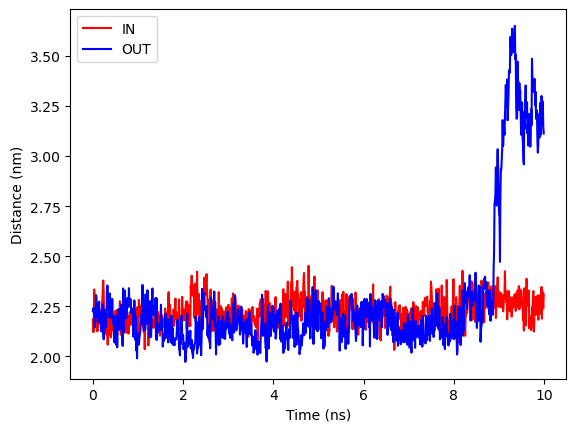

In [16]:
time = np.arange(0, data.shape[1])/100
plt.plot(time, data[1, :, -1], label="IN", c="r") #First simulation and last feature
plt.plot(time, data[-2, :, -1], label="OUT", c="b") #Last simulation and last feature 
plt.xlabel("Time (ns)")
plt.ylabel("Distance (nm)")
plt.legend();

As you can see, for example the last feature already gives away the outcome at later times. However, at early times there is overlap between the features. We can plot the values of this last feature for every simulation for the very first part of the data and we will see the overlap between outcomes: 

Text(0, 0.5, 'Distance (nm)')

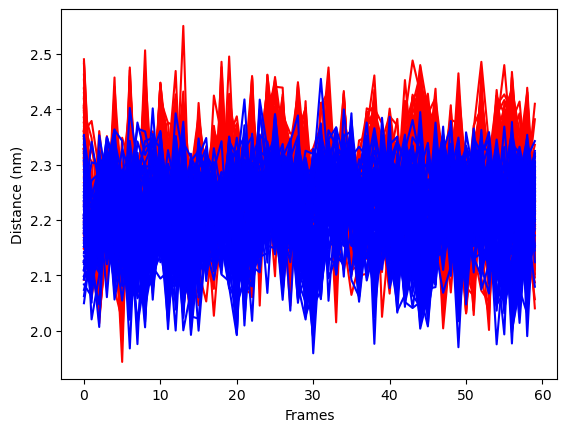

In [17]:
plt.plot(data[:60, :100, -1], c="r", label="IN") #First 60 are IN
plt.plot(data[-60:, :100, -1], c="b", label="OUT") #Last 60 are out
plt.xlabel("Frames")
plt.ylabel("Distance (nm)")

We will only use the early data for training purposes, so we will define it here, you can change it to experiment later. 

In [18]:
training_data = data[:,1:25, :]

### Step 2: Train the ML models

#### Preparing the training data

As with the preivous example in 4.1, the data corresponds to trajectories. We will use the MLP and GBDT models to predict the outcome of the simulations. But these models can only input 2D data, so we will have to concatenate the frames of the trajectories and assign a state for each frame. 

In [19]:
X = np.concatenate(training_data)
template = []
for answer in outcomes:
    tmp = np.zeros(training_data.shape[1]).astype(str)
    tmp[:] = answer
    template.append(tmp)
Y = np.concatenate(template)

In [20]:
print("Input data:", X.shape,"Outcomes:", Y.shape)

Input data: (3168, 224) Outcomes: (3168,)


Now that we have prepared our X and Y for training, we have to create the training/test split so we can test how accurate our ML model is at predicting on samples it has never seen. For this we will use a very convinient function from scikit-learn `train_test_split()` which already splits the data randomly and gives you back the parts so you can use it further down the pipeline. 

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=0) #33% will be stored for testing

#### Defining the ML models

Now we will define our classifiers to forecast the outcomes with  `MLPClassifier()` and `GradientBoostingClassifier()` from scikit-learn. 

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

MLP = MLPClassifier(random_state=42, verbose=1, max_iter=500, n_iter_no_change=50) #Neural Network (Multi-Layer Perceptron)
GBDT = GradientBoostingClassifier(random_state=42, n_estimators=100, verbose=1) #Gradient Boosting Decision Tree

#### Training and validation

Now let's use `X_train` and `Y_train` to fit our models and then use the `X_test` to predict the outcome `Y_pred`, and compare it to `Y_test` to asses the accuracy score. This models have the `verbosity=True`  by default, set it to `verbosity=False` in the previous cell if you don't want get output status from the training. 

In [23]:
print("Training MLP")
MLP.fit(X_train, Y_train) #Training until convergence done by sk-learn
print("Evaluating")
Y_pred = MLP.predict(X_test) #Predicting with the model
accuracy = Y_pred == Y_test #Assesing accuracy
print("Accuracy on test is ", np.mean(accuracy)*100, "%")

Training MLP
Iteration 1, loss = 0.85563594
Iteration 2, loss = 0.71258135
Iteration 3, loss = 0.69294884
Iteration 4, loss = 0.68029058
Iteration 5, loss = 0.67762732
Iteration 6, loss = 0.66718252
Iteration 7, loss = 0.66070535
Iteration 8, loss = 0.65649952
Iteration 9, loss = 0.66180363
Iteration 10, loss = 0.65662928
Iteration 11, loss = 0.64480775
Iteration 12, loss = 0.64221406
Iteration 13, loss = 0.63224905
Iteration 14, loss = 0.62976070
Iteration 15, loss = 0.63415614
Iteration 16, loss = 0.63444523
Iteration 17, loss = 0.62846186
Iteration 18, loss = 0.62366369
Iteration 19, loss = 0.62516290
Iteration 20, loss = 0.61439646
Iteration 21, loss = 0.61782137
Iteration 22, loss = 0.62267705
Iteration 23, loss = 0.61052178
Iteration 24, loss = 0.60905775
Iteration 25, loss = 0.60588367
Iteration 26, loss = 0.62257340
Iteration 27, loss = 0.62155667
Iteration 28, loss = 0.62936511
Iteration 29, loss = 0.60060764
Iteration 30, loss = 0.59972356
Iteration 31, loss = 0.60158332
Iter

/home/berta/anaconda3/envs/workshop/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


To check if our NN has converged indeed we can take a look at the loss function. If your computer allows, you can run for longer iterations or with more data and see if the accuracy improves. 

Text(0.5, 0, 'Iterations')

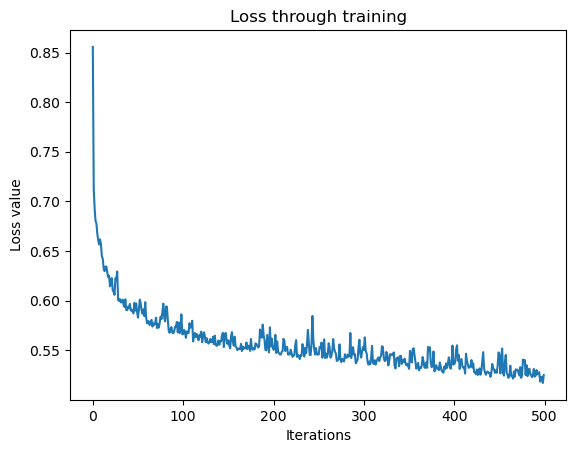

In [24]:
plt.title("Loss through training")
plt.plot(MLP.loss_curve_)
plt.ylabel("Loss value")
plt.xlabel("Iterations")

Let's train the GBDT now, in the same way as we did with the MLP:

In [25]:
print("Training GBDT")
GBDT.fit(X_train, Y_train)
print("Evaluating")
Y_pred = GBDT.predict(X_test)
accuracy = Y_pred == Y_test
print("Accuracy on test is ", np.mean(accuracy)*100, "%")

Training GBDT
      Iter       Train Loss   Remaining Time 
         1           1.3318           11.51s
         2           1.2868           11.38s
         3           1.2491           11.76s
         4           1.2176           11.45s
         5           1.1896           11.15s
         6           1.1662           10.80s
         7           1.1458           10.62s
         8           1.1274           10.64s
         9           1.1111           10.46s
        10           1.0969           10.30s
        20           0.9996            9.08s
        30           0.9416            7.85s
        40           0.8907            6.71s
        50           0.8461            5.60s
        60           0.8045            4.46s
        70           0.7663            3.33s
        80           0.7359            2.22s
        90           0.7052            1.11s
       100           0.6739            0.00s
Evaluating
Accuracy on test is  72.08413001912047 %


We can also monitor how the loss of the GBDT has been improving thourgh the different estimators used. If your computer allows, you can run for longer iterations or with more data and see if the accuracy improves. 

Text(0, 0.5, 'Loss')

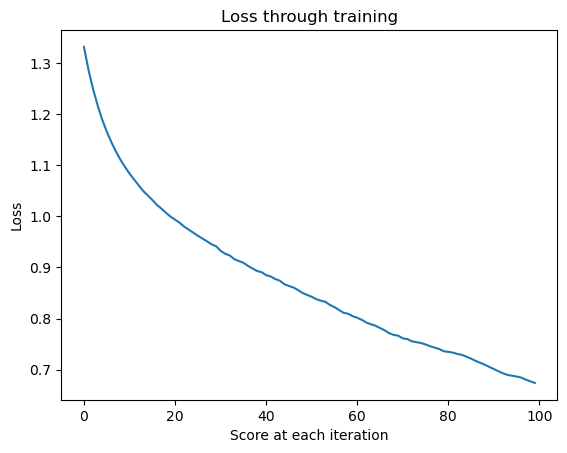

In [26]:
plt.title("Loss through training")
plt.plot(GBDT.train_score_)
plt.xlabel("Score at each iteration")
plt.ylabel("Loss")

### Step 3: Feature Analysis

#### GBDT Gini Feature Importances 

Since the training with GBDT comes with the calculated feature importances, we can simply call `model.feature_importances_` to retrieve them. Out of those we can check the most relevant ones. Usually these come in a 1/n_features, so they all add up to 1. Let's plot them:

Text(0, 0.5, 'Feature Importance')

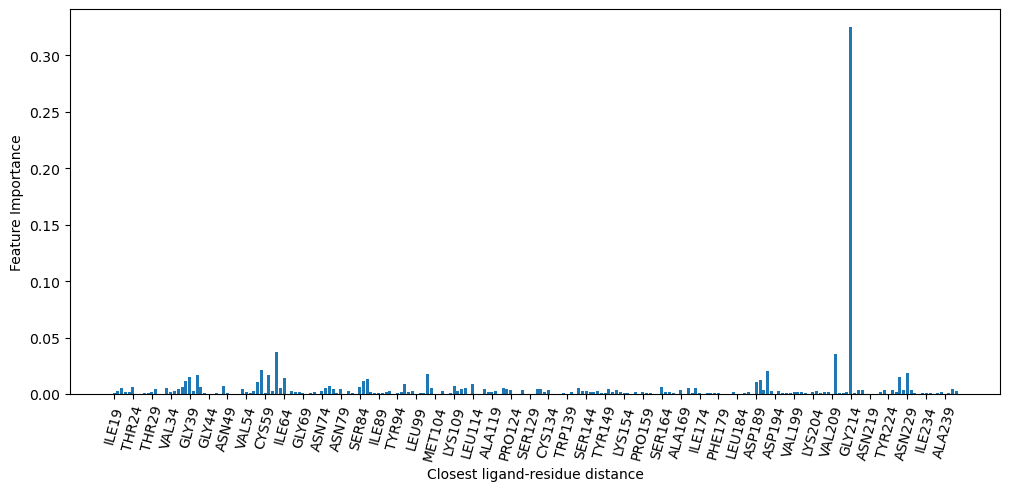

In [27]:
 #We need this to know what each feature means, this is the residue that the distance to the ligand originates from. 
feat_names = np.load("data/allres_features.npy", allow_pickle=True)
FIs = GBDT.feature_importances_ #Obtaining the importances
#Now to plotting:
plt.figure(figsize=(12,5))
plt.bar(range(0, len(FIs)), FIs)
plt.xticks(range(0, len(FIs))[::5], feat_names[::5], rotation=75)
plt.xlabel("Closest ligand-residue distance")
plt.ylabel("Feature Importance")

We may want to check now the top features, so let's look at the top 5:

In [28]:
n_top_features = 5
GBDT_tops = np.argsort(-GBDT.feature_importances_)[:n_top_features]
print("Most relevant features are:", GBDT_tops)

Most relevant features are: [195  43 191  39 173]


#### MLP Accuracy Drop

For the MLP, however, we will have to do a bit more work. We will have to call the `ADROP()` function from the MLTSA package to calculate the accuracy drops. 

In [29]:
#This will calculate the global mean, and iterate through the data re-predicting one at a time
accuracy_drop = ADROP(training_data, outcomes, MLP)
ADs = np.mean(accuracy_drop, axis=0)

132it [00:17,  7.70it/s]


Text(0, 0.5, 'Accuracy (%)')

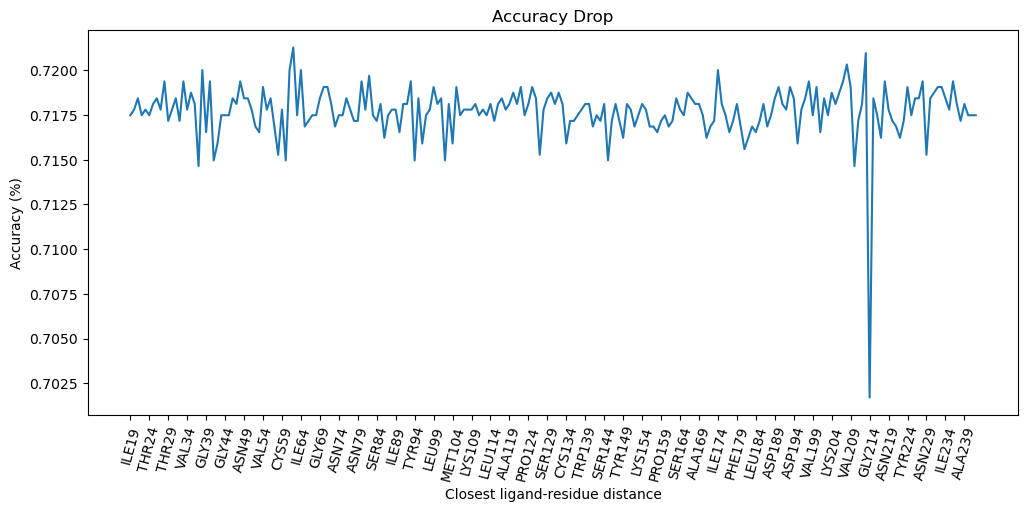

In [30]:
plt.figure(figsize=(12,5))
plt.title("Accuracy Drop")
plt.plot(range(0, len(ADs)), ADs)
plt.xticks(range(0, len(ADs))[::5], feat_names[::5], rotation=75)
plt.xlabel("Closest ligand-residue distance")
plt.ylabel("Accuracy (%)")

We may want to check now the top features, so let's look at the top 5:

In [31]:
n_top_features = 5
MLP_tops = np.argsort(ADs)[:n_top_features]
print("Most relevant features are:", MLP_tops)

Most relevant features are: [195 191  18 126  75]


#### Feature Analysis

How do the results for GBDT and MLP look like? Are they similar? Let's make an all in one plot to compare them. 

Text(0.5, 0, 'Protein residue involved in distance')

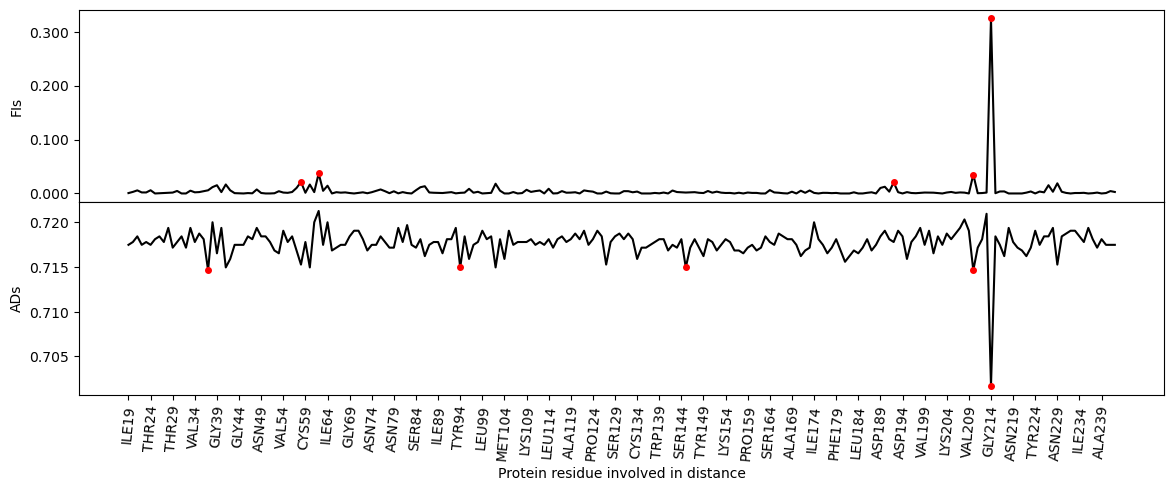

In [32]:
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

###FI stuff 
axs[0].plot(FIs, color="black")
axs[0].plot(GBDT_tops, FIs[GBDT_tops],"o",  color="red", markersize=4)

###AD stuff
axs[1].plot(ADs, color="black")
axs[1].plot(MLP_tops, ADs[MLP_tops], "o",  color="red", markersize=4)

####Fancy decorations
axs[0].set_ylabel("FIs", multialignment='center')
axs[1].set_ylabel("ADs",  multialignment='center')
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.xticks(range(0, len(feat_names))[::5], feat_names[::5], rotation=85)
plt.xlabel("Protein residue involved in distance")


We clearly see one feature that is the clear winner in this case. Let's take a look more in detail and get the histograms for that feature. 

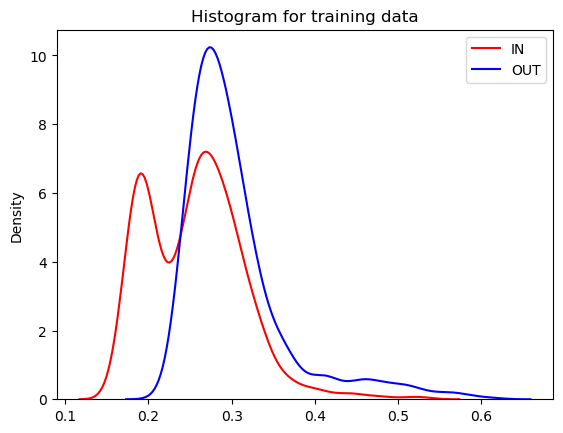

In [33]:
top_feature = GBDT_tops[0] #Introduce the feature you wish to check

plt.figure()
plt.title("Histogram for training data")
sns.kdeplot(np.concatenate(training_data[:65,:,top_feature]), c="r", label="IN")
sns.kdeplot(np.concatenate(training_data[-65:,:,top_feature]), c="b", label="OUT")
plt.legend()

Now we see that there is some overlap, where the IN gets towards a lower value and the OUT shifts to higher values. Let's visualize the 2 top features for both MLP and GBDT to see if the data can explain more:

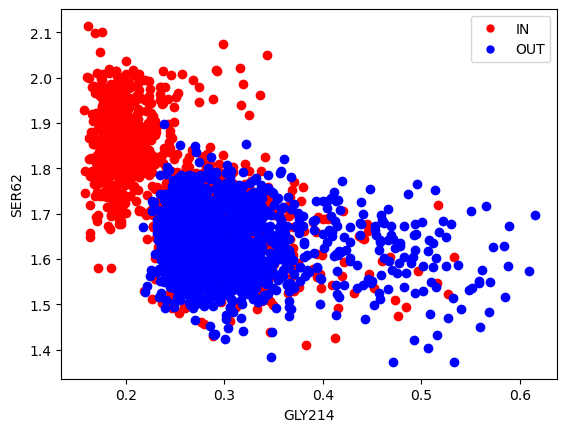

In [34]:
top2_features = GBDT_tops[:2]

plt.plot(training_data[:65,:,top2_features[0]], training_data[:65,:,top2_features[1]], "o", c="r", label="IN");
plt.plot(training_data[-65:,:,top2_features[0]], training_data[-65:,:,top2_features[1]], "o", c="b", label="OUT");
plt.xlabel(feat_names[top2_features[0]])
plt.ylabel(feat_names[top2_features[1]])

####Bit of magic for the legend
custom = [
    Line2D([0], [0], marker='o', color='r', label='Scatter', markerfacecolor='r', markersize=5, linewidth=0),
    Line2D([0], [0], marker='o', color='b', label='Scatter', markerfacecolor='b', markersize=5, linewidth=0)
         ]
plt.legend(custom, ['IN', 'OUT'])

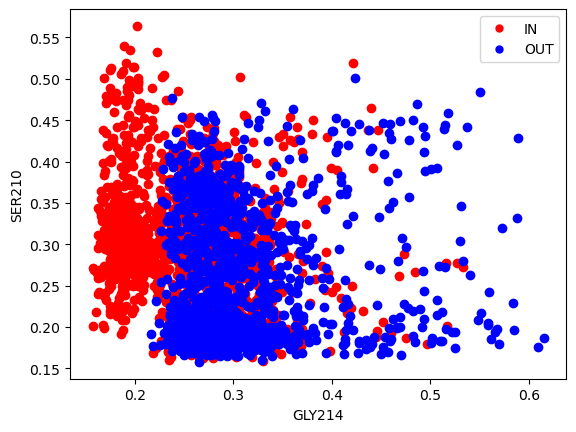

In [35]:
top2_features = MLP_tops[:2]

plt.plot(training_data[:65,:,top2_features[0]], training_data[:65,:,top2_features[1]], "o", c="r");
plt.plot(training_data[-65:,:,top2_features[0]], training_data[-65:,:,top2_features[1]], "o", c="b");
plt.xlabel(feat_names[top2_features[0]])
plt.ylabel(feat_names[top2_features[1]])

####Bit of magic for the legend
custom = [
    Line2D([0], [0], marker='o', color='r', label='Scatter', markerfacecolor='r', markersize=5, linewidth=0),
    Line2D([0], [0], marker='o', color='b', label='Scatter', markerfacecolor='b', markersize=5, linewidth=0)
         ]
plt.legend(custom, ['IN', 'OUT'])

## Optional tasks


We recommend if time allows, or at home, to try the following:
- Try increasing/decreasing the number of iterations/estimators for GBDT and MLP, how does the accuracy change?
<!-- ***Answer:*** The accuracy may increase when increasing the iterations and decrease when it has less trains .-->
- Try also changing the time_frame at which we predict, what is the accuracy at later times? What about earlier? The whole trajectory?.
<!-- ***Answer:*** At later times it should be easier to predict whereas at earlier times it should be harder .-->
- When changing the time_frame, do the relevant features change?.
<!-- ***Answer:***.-->
